<h3>Импорт библиотек</h3>
<p>Загрузка всех необходимых библиотек для работы с аудио, построения модели и визуализации результатов.</p>
<hr>

In [417]:
import librosa
import os
import random
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping, ModelCheckpoint
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch
from sklearn.utils.class_weight import compute_class_weight

<h3>Фиксация random seed</h3>
<p>Устанавливаем значения random seed для всех библиотек, чтобы обеспечить воспроизводимость результатов эксперимента.</p>
<hr>

In [418]:
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

<h3>Проверка наличия GPU</h3>
<p>Определяем, есть ли в системе GPU, и выводим используемое устройство.</p>
<hr>

In [419]:
has_gpu = len(tf.config.list_physical_devices('GPU')) > 0
device_name = '/GPU:0' if has_gpu else '/CPU:0'
print(f"Используется устройство: {device_name}")

Используется устройство: /GPU:0


<h3>Загрузка датасета</h3>
<p>Загрузка CSV-файла с путями к аудиофайлам и соответствующими метками эмоций.</p>
<hr>

In [420]:
df = pd.read_csv('../files/paths_labels_csv/ravdess_paths_and_labels.csv', sep=',')

<h3>Глобальные параметры аудио</h3>
<p>Задаём параметры: частоту дискретизации, длительность аудиофрагмента и число коэффициентов MFCC.</p>
<hr>

In [421]:
SAMPLE_RATE = 22050
DURATION = 3
N_MELS = 128
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

<h3>Аугментации аудио</h3>
<p>Создаём пайплайн аугментаций для обучающих аудиофайлов: добавление шума, pitch shift и time stretch.</p>
<hr>

In [422]:
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.6),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.4)
])

<h3>Функция препроцессинга аудио</h3>
<p>Функция загружает аудиофайл, применяет аугментацию (при необходимости), вычисляет MFCC и нормализует результат.</p>
<hr>

In [423]:
def preprocess_audio(file_path, augment=False):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION, mono=True)
    if len(y) < SAMPLES_PER_TRACK:
        pad_width = SAMPLES_PER_TRACK - len(y)
        y = np.pad(y, (0, pad_width))
    else:
        y = y[:SAMPLES_PER_TRACK]

    if augment:
        y = augmenter(samples=y, sample_rate=sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)
    return mfcc

<h3>Преобразование аудио в MFCC и формирование датасета</h3>
<p>Обрабатываем все аудиофайлы: вычисляем MFCC для каждого и создаём массивы признаков и меток.</p>
<hr>

In [424]:
X = []
y = []

label_to_idx = {label: idx for idx, label in enumerate(sorted(df['emotion'].unique()))}

for idx, row in tqdm(df.iterrows(), total=len(df)):
    mel_spec = preprocess_audio(row['path'])
    X.append(mel_spec)
    y.append(label_to_idx[row['emotion']])

X = np.array(X)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

100%|██████████| 1440/1440 [00:08<00:00, 173.75it/s]

X shape: (1440, 40, 130)
y shape: (1440,)


<h3>Визуализация MFCC-спектрограммы</h3>
<p>Строим изображение MFCC для первого примера — это важно для контроля качества препроцессинга.</p>
<hr>

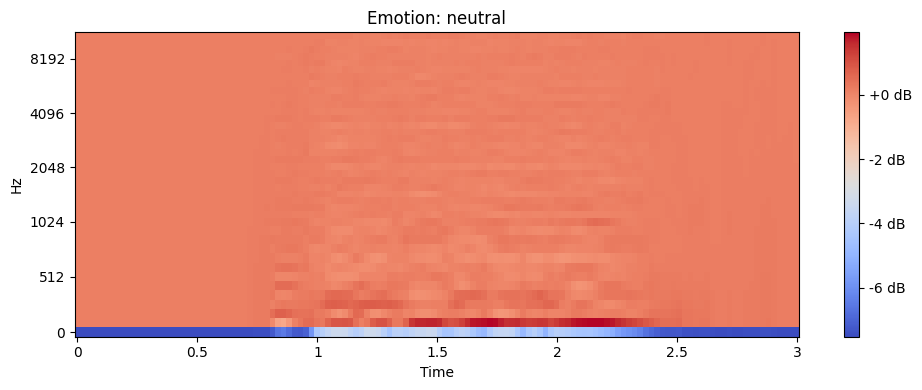

In [425]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[0].squeeze(), sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
plt.title(f'Emotion: {df["emotion"].iloc[0]}')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

<h3>Изменение формы массива X</h3>
<p>Добавляем размерность для канала (channel) для совместимости с Conv2D-слоями Keras.</p>
<hr>

In [426]:
X = X[..., np.newaxis]
print("X shape:", X.shape)

X shape: (1440, 40, 130, 1)


<h3>Разделение на обучающую и тестовую выборки</h3>
<p>Делим данные на train/test в соотношении 80/20 с учётом баланса классов.</p>
<hr>

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

<h3>One-hot encoding меток</h3>
<p>Преобразуем числовые метки в one-hot вектор для многоклассовой классификации.</p>
<hr>

In [428]:
num_classes = len(np.unique(y))

In [429]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

<h3>Финальная архитектура модели</h3>
<p>Определяем итоговую модель с несколькими сверточными и полносвязными слоями.</p>
<hr>

In [430]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

<h3>Callbacks для обучения</h3>
<p>Настраиваем EarlyStopping и ModelCheckpoint для предотвращения переобучения и сохранения лучших весов.</p>
<hr>

In [431]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_ckpt = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


callbacks = []

<h3>Взвешивание классов</h3>
<p>Рассчитываем веса для классов, чтобы учесть их дисбаланс при обучении модели.</p>
<hr>

In [432]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.935064935064935, 1: 0.935064935064935, 2: 0.935064935064935, 3: 0.9411764705882353, 4: 0.9411764705882353, 5: 1.87012987012987, 6: 0.935064935064935, 7: 0.9411764705882353}


<h3>Компиляция и обучение модели</h3>
<p>Компилируем модель и запускаем процесс обучения с использованием аугментаций, весов классов и callbacks.</p>
<hr>

In [433]:
with tf.device(device_name):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0007),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', 'categorical_accuracy']
    )

    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_test, y_test_cat),
        epochs=100,
        batch_size=32,
        # callbacks=callbacks,
        class_weight=class_weights_dict
    )

Epoch 1/100
36/36 [==============================] - 1s 19ms/step - loss: 2.5202 - accuracy: 0.2049 - categorical_accuracy: 0.2049 - val_loss: 2.7992 - val_accuracy: 0.1319 - val_categorical_accuracy: 0.1319
Epoch 2/100
36/36 [==============================] - 0s 9ms/step - loss: 1.9315 - accuracy: 0.2665 - categorical_accuracy: 0.2665 - val_loss: 4.3899 - val_accuracy: 0.1319 - val_categorical_accuracy: 0.1319
Epoch 3/100
36/36 [==============================] - 0s 9ms/step - loss: 1.8704 - accuracy: 0.2986 - categorical_accuracy: 0.2986 - val_loss: 5.5238 - val_accuracy: 0.1319 - val_categorical_accuracy: 0.1319
Epoch 4/100
36/36 [==============================] - 0s 9ms/step - loss: 1.8422 - accuracy: 0.3142 - categorical_accuracy: 0.3142 - val_loss: 5.5449 - val_accuracy: 0.1319 - val_categorical_accuracy: 0.1319
Epoch 5/100
36/36 [==============================] - 0s 9ms/step - loss: 1.7989 - accuracy: 0.3212 - categorical_accuracy: 0.3212 - val_loss: 5.7422 - val_accuracy: 0.1319

<h3>Оценка точности на тестовой выборке</h3>
<p>Вычисляем метрику accuracy и categorical accuracy на тестовой выборке.</p>
<hr>

In [434]:
test_loss, test_acc, cat_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Categorical test accuracy: {cat_acc:.4f}")

Test accuracy: 0.6979
Categorical test accuracy: 0.6979


<h3>Визуализация истории обучения</h3>
<p>Строим графики изменения точности на обучающей и валидационной выборках по эпохам.</p>
<hr>

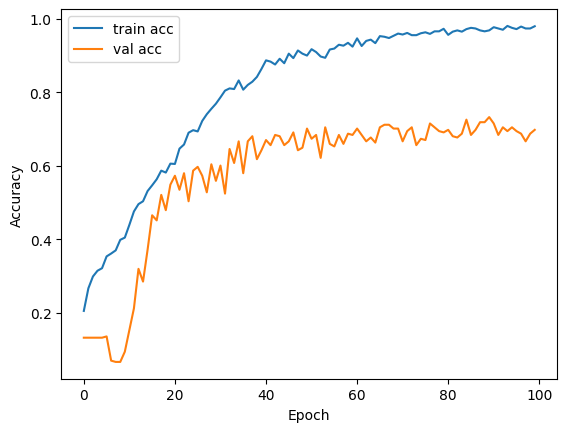

In [435]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h3>Анализ баланса классов</h3>
<p>Выводим количество примеров для каждого класса — важно для оценки сбалансированности данных.</p>
<hr>

In [436]:
print(df['emotion'].value_counts())

emotion
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64


<h3>Построение матрицы ошибок (Confusion Matrix)</h3>
<p>Визуализируем, как модель путает разные классы эмоций на тестовой выборке.</p>
<hr>

9/9 [==============================] - 0s 2ms/step


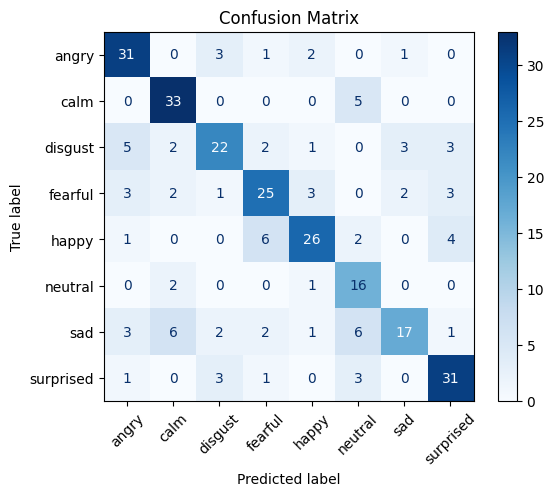

In [437]:
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test_cat, axis=1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df['emotion'].unique()))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()